In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader,datetime
import pandas_datareader.data as web
from datetime import date 
import operator, math
import yfinance as yf
import yahoo_fin.stock_info as si

In [12]:
class StockOfToday:
    
    # Class used to represent Stock prices Dataframe
    def __init__(self, ticker, start_date, end_date,shares=0):
        
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker
        self.stock = web.DataReader(self.ticker,'yahoo', self.start_date, self.end_date)
        self.shares = shares
        
    # Returns dictionary of stock ticker and cumelative return within given timeframe
    def cumel_dict(self):
        self.stock['Returns'] = self.stock['Adj Close'].pct_change(1)
        self.stock['Cumulative Return'] = (1 + self.stock['Returns']).cumprod()
        cumel_value = self.stock['Cumulative Return'].iloc[-1].round(4)
        return {self.ticker:cumel_value}
    
    #Returns stock df with all price info
    def return_stock_df(self):
        return self.stock
    
    # Returns string of ticker symbol
    def return_stock_ticker(self):
        return self.ticker
    
    # Returns string of start date
    def return_stock_start_date(self):
        return self.start_date
    
    # Returns string of end date
    def return_stock_end_date(self):
        return self.end_date
    
    # Returns number of shares allocated by user
    def return_num_shares(self):
        return self.shares
    
    # Determines how many days of teh given date range to calculate std and mean, this case 10%
    def days_to_calc(self):
        return int(round((self.stock['Adj Close'].count())*.1))
    
    # Returns stock dividend df 
    def return_stock_div(self):
        div_df = pd.DataFrame(yf.Ticker(self.ticker).dividends)       
        if(div_df.size==0):
            date_time_str = self.start_date
            date_time_obj = datetime.datetime.strptime(date_time_str, '%m-%d-%Y')
            return pd.DataFrame(columns=['Dividends'],index=[date_time_obj]).fillna(0)
        else:    
            return div_df
    
    # Returns last adjusted close stock price within given timeframe 
    def return_last_adj_close(self):
        return self.return_stock_df()['Adj Close'][-1]
    
    # Returns df used to plot mean and std
    def rolling_mean_and_std_df(self):
        delta = self.days_to_calc()
        self.stock['Rolling Mean'] = self.stock['Adj Close'].rolling(delta).mean()
        self.stock['Rolling STD'] = self.stock['Adj Close'].rolling(delta).std()
        return self.stock[['Adj Close','Rolling STD','Rolling Mean']]
    
    # Returns kde calculation column df
    def kde_df(self):
        return self.stock['Adj Close'].pct_change(1)
    
    # Returns calculated df column of cumelative returns 
    def cumelative_return(self):
        self.stock['Returns'] = self.stock['Adj Close'].pct_change(1)
        self.stock['Cumulative Return'] = (1 + self.stock['Returns']).cumprod()
        return self.stock['Cumulative Return']
    
    # Returns df of company liabilities and assets, used in total_df(self) 
    def stock_finantial_df(self): 
        try:
            finantial_df = si.get_balance_sheet(self.ticker)
        except KeyError as k:
            print('\n')
            print('Error with '+str(k)+': stock must not have ballance sheet, try non-ETFs for this information')
            print('\n')
            
        total_liabil = finantial_df.loc['totalLiab'] #correct
        total_stock_holder_equity = finantial_df.loc['totalStockholderEquity']
        total_assets = finantial_df.loc['totalAssets'] #correct

        df1 = pd.DataFrame(total_liabil)
        df2 = pd.DataFrame(total_stock_holder_equity)
        df3 = pd.DataFrame(total_assets)

        liab_asset_df = pd.concat([df1,df2,df3],axis=1)
        liab_asset_df['debt_to_equity(D/E)'] = liab_asset_df['totalLiab']/liab_asset_df['totalStockholderEquity']
        return liab_asset_df
    
    #Returns company revenue and earnings over datas available timeframe
    def return_yearly_rev_earning(self):
        try:
            rev = si.get_earnings(self.ticker)
        except KeyError as k:
            print('\n')
            print('Error with '+str(k)+': stock must not have ballance sheet, try non-ETFs for this information')
            print('\n')
        yearly_rec_df = rev.get('yearly_revenue_earnings')
        yearly_rec_df.set_index(yearly_rec_df['date'],inplace=True)
        return yearly_rec_df[['revenue','earnings']]
     
    #checks if stock has dividend info
    def has_divs(self):
        if (len(self.return_stock_div()['Dividends']) > 2):
            return True
        else: return False
    


In [13]:
class stock_of_today_list():
    
    # Class that initializes an instances of Stock Of Today objects in list form 
    def __init__(self,stock_list,allo):
        self.stock_list = stock_list
        self.sharpe_allo_num = allo
    
    # Returns list of Stock Of Today objects
    def return_stock_list(self):
        return self.stock_list
    
    # Returns SP500 stock df as benchmark in plots
    def SP500_benchmark_df(self):
        SP500 = web.DataReader('SPY','yahoo',self.stock_list[0].return_stock_start_date(),self.stock_list[0].return_stock_end_date())
        SP500['SP500_KDE'] = SP500['Adj Close'].pct_change(1)
        SP500['Returns'] = SP500['Adj Close'].pct_change(1)
        SP500['Cumulative Return'] = (1 + SP500['Returns']).cumprod()
        return SP500
    
    # Used in def colors(self,n) to return evenly spaced rgb values
    def colors_helper(self,n): 
        ret = []
        r = np.random.randint(256)
        step = 256 / n 
        for i in range(n): 
            r += step 
            r = int(r) % 256 
            R=round(r/256,3)
            ret.append(R)
        return ret 
    
    # Returns evenly spaced and mostly unique, rgb colors
    def colors(self,n): 
        ret = []
        s =len(self.stock_list)
        R=self.colors_helper(s)
        G=self.colors_helper(s)
        B=self.colors_helper(s)
        for i in range(0,s):
            ret.append((R[i],G[i],B[i]))
        return ret

    # Plots kde plot of stock standard deviation over given timeframe
    def volitility(self):
        color_list = self.colors(len(self.stock_list))
        fig, sub_plots = plt.subplots(figsize=(15,10),squeeze = False)
        ind = 0
        for i in self.stock_list:
            i.kde_df().plot(kind='kde',ax=sub_plots[0,0],label=i.return_stock_ticker(),c=color_list[ind])
            ind+=1
        self.SP500_benchmark_df()['SP500_KDE'].plot(kind='kde',ax=sub_plots[0,0],label='SP500',alpha=.6,ls='--',c='red')
        plt.legend()
        plt.show()

    # Calculates cumelative returns over given timeframe
    def cumelative_return(self):
        dict_append = {}
        #n rows by 1 col
        fig, sub_plots = plt.subplots(len(self.stock_list),1,figsize=(20,10),squeeze=False)
        for stock in range(0,(len(self.stock_list))):
            dict_append.update(self.stock_list[stock].cumel_dict())
            y_axis = (1 + self.stock_list[stock].return_stock_df()['Adj Close'].pct_change(1)).cumprod()
            sub_plots[stock,0].plot(y_axis.index,y_axis)
            sub_plots[stock,0].set_ylabel(self.stock_list[stock].return_stock_ticker())
        
        sorted_d = sorted(dict_append.items(), key=operator.itemgetter(1))
        print('Sorted cumelative returns: '+ str(sorted_d)  )      
        
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.style.use('seaborn')
        plt.show()
    
    # Returns sorted dictionary of stock ticker and numeric cumelative return; plots cumelative returns
    def cumel_box_plot(self):
        dict_append = {}
        for i in self.stock_list:
            dict_append.update(i.cumel_dict())
    
        sorted_d = dict(sorted(dict_append.items(), key=operator.itemgetter(1)))
        print(sorted_d)
        print('\n')
        
        df = pd.DataFrame.from_dict(sorted_d,orient='index',columns=['value'])
        y = df['value']
        low = min(y)
        high = max(y)
        
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.bar(df.index,y) 
        
        #horizontal line
        plt.axhline(y = 1.2, color = 'r', linestyle = '--') 
        plt.axhline(y = 1.4, color = 'blue', linestyle = '--') 
        
        plt.style.use('seaborn')
        plt.show()

    # Plots a cumilative return graph of each stock based on the given timeframe    
    def mean_std_plot(self):
        for i in self.stock_list:
            i.rolling_mean_and_std_df().plot(figsize=(20,8))
        plt.title(i.return_stock_ticker())
        plt.show()
    
    # Plots dividend trends
    def dividend_plot(self):
        
        print('\n')
        print('Dividend data based on Yahoo Finance free data\n')
        print('\n')
        
        for i in self.stock_list:
            fig, sub_plots = plt.subplots(1,3,figsize=(20,10),squeeze = False)
            dividend_df = i.return_stock_div()
            
            if(dividend_df.size<1):
                print('NO DIVIDEND INFO FOR: '+ i.return_stock_ticker())
            merged_stock_div_df = i.return_stock_df().merge(dividend_df, left_index=True, right_index=True)
        
        #within given time frame dividend plot
            sub_plots[0, 0].plot(merged_stock_div_df.index,merged_stock_div_df['Dividends'],label=str(i.return_stock_ticker()))
            sub_plots[0, 0].set_xlabel('Most Recent Dividend Data')
            sub_plots[0, 0].set_ylabel('$ per Share')

        #historic dividend plot
            x = dividend_df.index
            y = dividend_df['Dividends']
            sub_plots[0, 1].plot(x,y,label=str(i.return_stock_ticker()))
            sub_plots[0, 1].plot(x,y.rolling(int(round((dividend_df.size*.15)))).mean()) #rolling mean
            sub_plots[0, 1].set_xlabel('Historic Dividend Data')
           
        #relevant time frame div plot
            x_r = dividend_df.iloc[int(round((dividend_df.size/2))):].index
            y_r = dividend_df.iloc[int(round((dividend_df.size/2))):]['Dividends']
            sub_plots[0, 2].plot(x_r,y_r,label=str(i.return_stock_ticker()))
            sub_plots[0, 2].plot(x_r,y_r.rolling(int(round((dividend_df.size*.1)))).mean(),label='Rolling Mean') #rolling mean
            sub_plots[0, 2].set_xlabel('Relevant Dividend Data')
        
            plt.legend()
            plt.tight_layout()
            plt.show()

        fig.autofmt_xdate()
        
    # Box plot overall dividend % returns
    def dividend_info(self):
        fig, sub_plots = plt.subplots(1,2,figsize=(20,10),squeeze = False)
        
        x1 = self.return_div_df()['div%per-year'].index
        y1 = self.return_div_df()['div%per-year']
        sub_plots[0, 0].bar(x1,y1,label='Dividend % return per year per Share')
        sub_plots[0, 0].set_ylabel('div%per-year')
        
        #horizontal ideal dividend return lines
        upper_lim = sub_plots[0,0].axhline(0.0166,color='red',ls='--')
        lower_lim = sub_plots[0,0].axhline(0.0444,color='blue',ls='--')
        
        x2 = self.return_div_df()['div $/Y'].index
        y2 = self.return_div_df()['div $/Y']
        
        x3= self.return_div_df()['div $/share(Q)'].index
        y3= self.return_div_df()['div $/share(Q)']
        
        sub_plots[0, 1].bar(x2,y2,label='Dividend return per year per Share ($)')
        sub_plots[0, 1].bar(x3,y3,label='Dividend return per Quarter per Share ($)')
        
        plt.legend()
        plt.tight_layout()
        fig.autofmt_xdate()
        plt.show()
    
    # Stock summary with average trend line, kde, and dividend plots
    def stock_summary(self):

        for s1 in self.stock_list:
            
            if s1.has_divs() == False:
                print('This Stock does not have Dividend Data\n')
                
                fig, sub_plots = plt.subplots(1,3,figsize=(15,5),squeeze = False)
            #rolling mean and std plot
                x = s1.rolling_mean_and_std_df().index
                y1 = s1.rolling_mean_and_std_df()['Adj Close']
                y2 = s1.rolling_mean_and_std_df()['Rolling Mean']
                y3 = s1.rolling_mean_and_std_df()['Rolling STD']

                sub_plots[0,0].plot(x,y1,label='Adj Close')
                sub_plots[0,0].plot(x,y2,label='Rolling Mean')
                sub_plots[0,0].plot(x,y3,label='Rolling STD')

                sub_plots[0, 0].set_title('Stock Trends')
                sub_plots[0, 0].set_ylabel('Stock Price')
                sub_plots[0, 0].legend()

            #kde plot
                s1.kde_df().plot(kind='kde',ax=sub_plots[0,1],label='KDE: Volitility')
                self.SP500_benchmark_df()['SP500_KDE'].plot(kind='kde',ax=sub_plots[0,1],label='SP500',alpha=.6,ls='--',c='red')
                sub_plots[0,1].set_title('KDE Plot')
                sub_plots[0,1].legend()


            #returns vs sp500 plot
                s1.cumelative_return().plot(ax=sub_plots[0,2],label=s1.return_stock_ticker())
                self.SP500_benchmark_df()['Cumulative Return'].plot(ax=sub_plots[0,2],label='SP500',alpha=.6,ls='--',c='red')
                sub_plots[0,2].set_ylabel('Cumelative Return (%)')
                sub_plots[0,2].set_title('Cumelative Returns VS SP500')
                sub_plots[0,2].legend()
                #break;



            else:
                fig, sub_plots = plt.subplots(2,2,figsize=(15,10),squeeze = False)

                #rolling mean and std plot
                x = s1.rolling_mean_and_std_df().index
                y1 = s1.rolling_mean_and_std_df()['Adj Close']
                y2 = s1.rolling_mean_and_std_df()['Rolling Mean']
                y3 = s1.rolling_mean_and_std_df()['Rolling STD']

                sub_plots[0,0].plot(x,y1,label='Adj Close')
                sub_plots[0,0].plot(x,y2,label='Rolling Mean')
                sub_plots[0,0].plot(x,y3,label='Rolling STD')

                sub_plots[0, 0].set_title('Stock Trends')
                sub_plots[0, 0].set_ylabel('Stock Price')
                sub_plots[0, 0].legend()

                #kde plot
                s1.kde_df().plot(kind='kde',ax=sub_plots[0,1],label='KDE: Volitility')
                self.SP500_benchmark_df()['SP500_KDE'].plot(kind='kde',ax=sub_plots[0,1],label='SP500',alpha=.6,ls='--',c='red')
                sub_plots[0,1].set_title('KDE Plot')
                sub_plots[0, 1].legend()


                #returns vs sp500 plot
                s1.cumelative_return().plot(ax=sub_plots[1,0],label=s1.return_stock_ticker())
                self.SP500_benchmark_df()['Cumulative Return'].plot(ax=sub_plots[1,0],label='SP500',alpha=.6,ls='--',c='red')
                sub_plots[1,0].set_ylabel('Cumelative Return (%)')
                sub_plots[1,0].set_title('Cumelative Returns VS SP500')
                sub_plots[1,0].legend()



                #historic dividend trend
                renamed_div = s1.return_stock_div().rename(columns = {'Dividends':'Historic Dividend Data'})
                renamed_div.plot(ax=sub_plots[1,1])

                renamed_div_mean = s1.return_stock_div().rename(columns = {'Dividends':'Dividend Mean'})
                renamed_div_mean.rolling(int(round((s1.return_stock_div().size*.1)))).mean().plot(ax=sub_plots[1,1],label='Dividend Rolling Mean') 

                sub_plots[1,1].set_ylabel('Dividend return per share ($)')
                sub_plots[1,1].set_title('Historic Dividend Trends')
                sub_plots[1,1].legend()

        

        plt.legend()
        plt.show()
    
    # Returns string list of stock tickers
    def return_ticker_list(self):
        temp = []
        for i in self.stock_list:
            temp.append(i.return_stock_ticker())
        return temp
    
    # Returns df of stocks and their Adj Close price, only used for sharpe_alloc(self,graph=False) method
    def stock_list_df(self):
        temp = []
        temp2 = []
        for i in self.stock_list:
            temp.append(i.return_stock_df()['Adj Close'])
            temp2.append(i.return_stock_ticker())
        stock = pd.concat(temp,axis=1)
        stock.columns=temp2
        return stock
    
    # Returns last Adj Close stock price, only used for sharpe_alloc(self,graph=False) method
    def return_last_price(self):
        temp = []
        for i in self.stock_list:
            temp.append(i.return_stock_df()['Adj Close'][-1])
        return temp
    
    # Sharpe ration graph, and $ to allocation of portfolio
    def sharpe_alloc(self,graph=False):    
        
        num_ports=12000
        np.random.seed(101)
        stocks = self.stock_list_df()
        log_return = np.log(stocks/stocks.shift(1))
        all_weights = np.zeros((num_ports,len(self.return_ticker_list())))
        ret_arr = np.zeros(num_ports)
        vol_arr = np.zeros(num_ports)
        sharpe_arr = np.zeros(num_ports)

        for i in range(num_ports):
            weights = np.array(np.random.random(len(self.return_ticker_list())))
            weights = weights / np.sum(weights)

            all_weights[i,:] = weights
            ret_arr[i] = np.sum(log_return.mean()*weights *252)
            vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
            sharpe_arr[i] = ret_arr[i] /vol_arr[i]

        max_sharpe= sharpe_arr[i].max()
        
        print('\n')
        print('Sharpe ratio: '+ str(max_sharpe))
        print('\n')
        
        max_sharpe_index_loc = sharpe_arr.argmax()
    
        #sharpe Ratio Calculations
        ser = pd.Series(data=all_weights[max_sharpe_index_loc,:],index=self.return_ticker_list())
        df = pd.DataFrame(ser,columns=['% to Allocate'])
        df['Dollar amount to Allocate($)'] = df['% to Allocate'].apply(lambda x: x*float(self.sharpe_allo_num))
        df.insert(2, 'last_price', self.return_last_price(), True) 
        df['#of shares to buy'] = df['Dollar amount to Allocate($)']/df['last_price']
        df['Round up nearest Share'] = df['#of shares to buy'].apply(lambda x: math.ceil(x))
        
        #if user wants graph to be displayed
        if(graph):
            plt.figure(figsize=(10,20))
            plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
            plt.colorbar(label='Sharpe Ratio')
            plt.xlabel('Volitility')
            plt.ylabel('Return')
            plt.scatter(vol_arr[max_sharpe_index_loc],ret_arr[max_sharpe_index_loc],c='red')
            plt.show()
            
            return df.sort_values(by=['% to Allocate'],ascending = False)
        return df.sort_values(by=['% to Allocate'],ascending = False)
    
    # Returns dataframe with dividend information
    def return_div_df(self):
        empty_dict = {}
        col_vals = ['last adj close','div $/share(Q)','div $/Y',
                    'div %/Y','#shares','equity',
                    'div-equity-year','div%per-year']

        for i in self.stock_list:
        
        #Indecies
            ticker = i.return_stock_ticker().upper()
        #0    
            last_adj_close = i.return_last_adj_close().round(3)
        #1 
            price_per_share = i.return_stock_div()['Dividends'][-1]
        #2    
            price_per_year = price_per_share*4
        #3    
            percent_per_year_percent = round((price_per_year/last_adj_close)*100,2)
        #4
            num_shares = i.return_num_shares()
        #5 
            equity = num_shares*last_adj_close
        #6
            div_equi_per_year = (num_shares*price_per_share)*4
        #7
            div_percent_per_year = price_per_year/last_adj_close

        # Dataframe columns
            div_features = [last_adj_close, price_per_share, price_per_year, 
                            percent_per_year_percent, num_shares, equity, div_equi_per_year,div_percent_per_year]
            empty_dict.update({ticker:div_features})
        return pd.DataFrame.from_dict(empty_dict,columns=col_vals,orient ='index').sort_values(by='div%per-year',ascending=False)

    # Returns dataframe with dividend and company information/metrics
    def total_df(self):
        div_df = self.return_div_df()
        sharpe_df = self.sharpe_alloc()
        total_df = pd.concat([div_df,sharpe_df],axis=1)
        temp = []
        for i in self.stock_list:
            temp.append(i.stock_finantial_df()['debt_to_equity(D/E)'][0])
        total_df.insert(1, "debt_to_equity(D/E)",temp, True)
        print('<1 more equity than debt, >1 more debt than equity')        
        return total_df
    
    # Plots company earnings and revenue 
    def plot_company_rev_trends(self):
        for i in self.stock_list:
            Y_AXIS_SCALE = 1000000000
            yearly_rec_df = i.return_yearly_rev_earning() / Y_AXIS_SCALE
            fig, sub_plots = plt.subplots(1,2,figsize=(15,5),squeeze = False)

            yearly_rec_df['revenue'].plot(ax=sub_plots[0,0],label='Revenue')
            sub_plots[0, 0].set_ylabel('Revenue (x 100 million)')
            sub_plots[0, 0].legend()

            yearly_rec_df['earnings'].plot(ax=sub_plots[0,1],label='Earnings/Net Income')
            sub_plots[0, 1].set_ylabel('Earnings (x 100 million)')
            sub_plots[0, 1].legend()

            plt.tight_layout()
            fig.autofmt_xdate()
            plt.show()
        


In [14]:
class stock_menu_looper():
    
    #Class that initializes an instance of Stock Of Today list object for menu options
    def __init__(self, alloc):
        start = input('Start date:')
        end = input('End date: ')
        self.alloc = alloc
        
        #checks for empty date
        if(len(start)<1 or len(end)<1):
            print('Need Correct Date Format')
            return main_menu()
        
        list_of_stocks = input('Enter individual or comma sporated list of Stock tickers (ex: tsla,aapl, ...): ')
        my_stocks = list_of_stocks.split(',')
        my_stock_objects = []
        
        #new Stock Of Today list object with 0$ allocated to portfolio
        if(self.alloc==0):
            for i in my_stocks:
                temp = StockOfToday(i.upper(),start,end)
                my_stock_objects.append(temp)
            self.s = stock_of_today_list(my_stock_objects,allo=0)
        
        #new Stock Of Today list object with no (allo)$ allocated to portfolio
        else:
            for i in my_stocks:
                temp = StockOfToday(i.upper(),start,end)
                my_stock_objects.append(temp)
            self.s = stock_of_today_list(my_stock_objects,allo = self.alloc)
    
    # Returns instance of Stock Of Today list object
    def init_stock_obj(self):
        return self.s


In [15]:
#Menu for executing methods to analyze individual or list of stocks
def stock_list_menu():
    
    try:
        s = stock_menu_looper(0)
    except:
        print('\n')
        print("Stock Ticker Not Found, Try again!")
        print('\n')
        
        return main_menu()
        
    #LIST MENU        
    #if s.stock_list_len()>1:
    if len(s.init_stock_obj().return_stock_list())>1:
        while 1>0:
            print('list menu')
            print (30 * "-" , "Stock-List Menu" , 30 * "-")
            print("""
                1. Compare Volitility

                2. Plot Cumelative Box Plot

                3. Plot Historic and Relevant Dividend Trends

                4. Plot Dividend Returns
                
                5. Main menu 
                """)
            print (67 * "-")
            
            ans = input("How do you want to analyze these stock?\n ")

            #1    
            if ans=="1":
                return s.init_stock_obj().volitility()
            #2
            elif ans=="2":
                return s.init_stock_obj().cumel_box_plot()
            #3
            elif ans == "3":
                return s.init_stock_obj().dividend_plot()
            #4
            elif ans == "4":
                return s.init_stock_obj().dividend_info()
            #5
            elif ans =="5":
                return main_menu()
            else:
                break;

    #INDIVIDUAL MENU
    else:
        while 1>0:
            print (30 * "-" , "Individual Stock Menu" , 30 * "-")
            print("""

        1. Plot Standard Deviation and Average Trends

        2. Plot Volitility 

        3. Plot Cumelative Returns

        4. Show Summary

        5. Company Revenue Trends

        6. Dividend Information

        7. Main Menu

                   """)
            print (67 * "-")
            ans = input("How do you want to analyze this stock?\n ")

            #1    
            if ans=="1":
                return s.init_stock_obj().mean_std_plot()
            #2    
            elif ans=="2":
                return s.init_stock_obj().volitility()
            #3
            elif ans=="3":
                return s.init_stock_obj().cumelative_return()
            #4
            elif ans=="4":
                return s.init_stock_obj().stock_summary()
            #5
            elif ans=="5":
                return s.init_stock_obj().plot_company_rev_trends()
            #6
            elif ans =="6":
                return s.init_stock_obj().dividend_plot()
            #7
            elif ans =="7":
                return main_menu()
            
            #back to menu
            else:
                return main_menu()
        

In [16]:
#Menu to analyze list of stocks and to analyze sharpe ratio of a portfolio
def portfolio_menu():
    
    print('List Menu')
    print (30 * "-" , "Stock-List Menu" , 30 * "-")
    print("""
        1. Sharpe Ratio and $ Allocation
        2. Company Finantials
        3. Main Menu
        """)
    print (67 * "-")
    
    ans = input("How do you want to analyze these stock?\n ")

    #1    
    if ans=="1":
        
        allo = input('How much to allocate ($) ?')
        to_graph = input('Would you like to see the Graph? (y/n)') 
        
        try:
            s = stock_menu_looper(allo)
        except:
            print('\n')
            print('Stock Ticker Not Found, Try again!2')
            print('\n')
            
            return portfolio_menu()
        
        if(str(to_graph)=="y"):
            return s.init_stock_obj().sharpe_alloc(graph=True)
        else:
            return s.init_stock_obj().sharpe_alloc()

    #2
    elif ans =="2":
        allo = input('How much to allocate ($) ?')
        try:
            s = stock_menu_looper(allo)
            df = s.init_stock_obj().total_df()
            return df[['last adj close','debt_to_equity(D/E)','div $/Y','div%per-year','% to Allocate']].loc[:, (df != 0).any(axis=0)]
        
        except:
            print('\n')
            print('Stock Ticker Not Found, Try again')
            print('\n')
            
            return portfolio_menu()
        return df.loc[:, (df != 0).any(axis=0)]

    #3
    elif ans =="3":
        return main_menu()


In [17]:
# Main menu, starting point to analysis stocks of interest
def main_menu():
    
    print (30 * "-" , "MENU" , 30 * "-")
    print("""
        1. Analyze an Individual or List of Stocks
        2. Portfolio
        3. Quit
       """)
    print (67 * "-")
    
    ans = input("What would you like to do?\n ")
    
    #1 main     
    if ans=="1":
        return stock_list_menu()
    
    #2 portfolio
    elif ans=="2":
        return portfolio_menu() 
    
    #3 exit
    elif ans =="3":
        print("\n Goodbye")
    
    else:
        print("\n Not a valid entry, try again")
        return main_menu()
    

------------------------------ MENU ------------------------------

        1. Analyze an Individual or List of Stocks
        2. Portfolio
        3. Quit
       
-------------------------------------------------------------------
List Menu
------------------------------ Stock-List Menu ------------------------------

        1. Sharpe Ratio and $ Allocation
        2. Company Finantials
        3. Main Menu
        
-------------------------------------------------------------------


Sharpe ratio: 1.1462521956841398




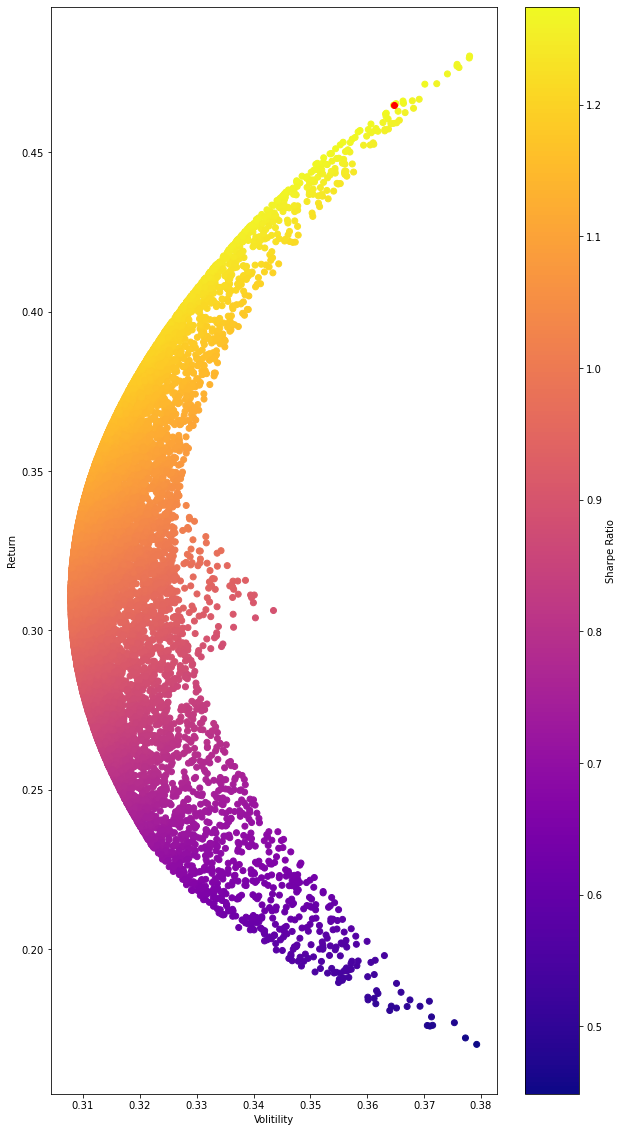

,% to Allocate,Dollar amount to Allocate($),last_price,#of shares to buy,Round up nearest Share
AAPL,0.898426,898.426351,126.849998,7.082589,8
HD,0.100983,100.983352,341.119995,0.296035,1
DIS,0.000590,0.590298,184.300003,0.003203,1


In [18]:
# Start Menu
main_menu()